<a href="https://colab.research.google.com/github/ariqnfl/hr-clustering/blob/main/cdx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
import itertools
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show
    
def age(born): 
    today = date.today() 
    return today.year - born.year - ((today.month,  today.day) < (born.month,  born.day))

In [3]:
df = pd.read_csv('hr-data.csv')

In [4]:
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,RoleID,LevelID,PerfScoreID,Tribe,Squad,DOB,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,RecruitmentSource,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,A Ridwan,10001,Not married,Single,M,TKP/ Outsource,Product Owner,Senior,Exceed,EWD,Evaluate,7/10/1983,Sunda,7/5/2011,NaN,N/A-StillEmployed,Active,LinkedIn,4.60,5,0,1/17/2020,0,1
1,Ade Setyanto,10002,Not married,Single,M,TKP/ Outsource,Product Owner,Senior,Fully meets,EWD,Pay,5/5/1975,Sunda,3/30/2015,6/16/2018,career change,Voluntarily Terminated,Indeed,4.96,3,6,2/24/2017,0,17
2,Adhitya Bramantya Ranggatyasta,10003,Married,Divorced,F,TKP/ Outsource,Product Owner,Senior,Average,ENT,HunianAja,9/19/1988,Jawa,7/5/2011,9/24/2014,hours,Voluntarily Terminated,LinkedIn,3.02,3,0,5/15/2013,0,3
3,Adji Wijaya Kusuma,10004,Not married,Single,F,TKP/ Outsource,Business Analyst,Middle,Exceed,ENT,Intermoda,9/27/1988,Cina,1/7/2008,NaN,N/A-StillEmployed,Active,Indeed,4.84,5,0,1/3/2020,0,15
4,Agus Andri Putra,10005,Not married,Single,F,Prohire,Business Analyst,Middle,Average,EDU,Squad Pijar Sekolah,9/8/1989,Bali,7/11/2011,9/6/2018,return to school,Voluntarily Terminated,Google Search,5.00,4,0,2/1/2017,0,2


In [5]:
df['DOB'] = pd.to_datetime(df.DOB)

df['Age'] = df['DOB'].apply(age)

df['Age_Cat'] = df.apply(lambda x: '28-35' if x.Age <= 35 else 
                            (
                                '36-43' if x.Age <= 43
                             else (
                                 '44-51' if x.Age <= 51
                                 else (
                                     '52-59' if x.Age <= 59
                                     else (
                                         '60-70')))), axis = 1)

df['DateofTermination'] = df['DateofTermination'].fillna(0)

df['JobLevel'] = df.apply(lambda x: 0 if 'Junior' in x.LevelID  else 
                            (
                                1 if 'Middle' in x.LevelID
                             else (
                                 2)),axis=1)

df['EmployeePerformance'] = df.apply(lambda x: 0 if 'Special treatment' in x.PerfScoreID else 
                                       (
                                           1 if 'Need improvement' in x.PerfScoreID
                                        else (
                                            2 if 'Average' in x.PerfScoreID
                                            else (
                                                3 if 'Fully meets' in x.PerfScoreID
                                                else (
                                                    4)))), axis=1)
df['Absence_Cat'] = df.apply(lambda x: 0 if x.Absences <= 5 else 
                               (
                                   1 if x.Absences <= 10
                                else (
                                    2 if x.Absences <= 15
                                    else (
                                         3))), axis = 1)
df['Late_Cat'] = df.apply(lambda x: 0 if x.DaysLateLast30 <= 0 else 
                            (
                                1 if x.DaysLateLast30 <= 2
                             else (
                                 2 if x.DaysLateLast30 <= 4
                                 else (
                                     3))), axis = 1)

df['YearofTermination'] = pd.DatetimeIndex(df['DateofTermination']).year
df['YearofHire'] = pd.DatetimeIndex(df['DateofHire']).year

today = date.today().year
df['WorkingYears'] = df.apply(lambda x: today - x.YearofHire if x.YearofTermination == 1970 else x.YearofTermination - x.YearofHire, axis=1)

df['WorkingYears_Cat'] = df.apply(lambda x: '0-5' if x.WorkingYears <= 5 else 
                            (
                                '6-10' if x.WorkingYears <= 10
                             else (
                                 '11-15')), axis = 1)

df['Resigned'] = df.apply(lambda x: 0 if x.EmploymentStatus == 'Active' else 1, axis=1)

df['EngagementSurvey'] = df['EngagementSurvey'].apply(round)

df = df.drop(columns=['Employee_Name','EmpID','LevelID','PerfScoreID','Tribe','Squad','DOB','RaceDesc','DateofHire','DateofTermination','Age','RecruitmentSource','LastPerformanceReview_Date','DaysLateLast30','Absences','YearofTermination','YearofHire','WorkingYears'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


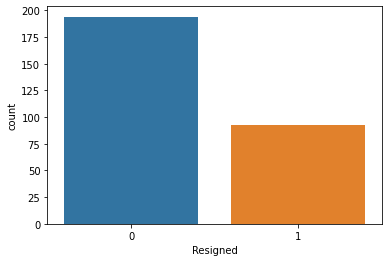

In [6]:
sns.countplot(df['Resigned'])

EDA

In [7]:
df.head()

,MarriedID,MaritalStatusID,GenderID,EmpStatusID,RoleID,TermReason,EmploymentStatus,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,Age_Cat,JobLevel,EmployeePerformance,Absence_Cat,Late_Cat,WorkingYears_Cat,Resigned
0,Not married,Single,M,TKP/ Outsource,Product Owner,N/A-StillEmployed,Active,5,5,0,36-43,2,4,0,0,6-10,0
1,Not married,Single,M,TKP/ Outsource,Product Owner,career change,Voluntarily Terminated,5,3,6,44-51,2,3,3,0,0-5,1
2,Married,Divorced,F,TKP/ Outsource,Product Owner,hours,Voluntarily Terminated,3,3,0,28-35,2,2,0,0,0-5,1
3,Not married,Single,F,TKP/ Outsource,Business Analyst,N/A-StillEmployed,Active,5,5,0,28-35,1,4,2,0,11-15,0
4,Not married,Single,F,Prohire,Business Analyst,return to school,Voluntarily Terminated,5,4,0,28-35,1,2,0,0,6-10,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MarriedID             287 non-null    object
 1   MaritalStatusID       287 non-null    object
 2   GenderID              287 non-null    object
 3   EmpStatusID           287 non-null    object
 4   RoleID                287 non-null    object
 5   TermReason            287 non-null    object
 6   EmploymentStatus      287 non-null    object
 7   EngagementSurvey      287 non-null    int64 
 8   EmpSatisfaction       287 non-null    int64 
 9   SpecialProjectsCount  287 non-null    int64 
 10  Age_Cat               287 non-null    object
 11  JobLevel              287 non-null    int64 
 12  EmployeePerformance   287 non-null    int64 
 13  Absence_Cat           287 non-null    int64 
 14  Late_Cat              287 non-null    int64 
 15  WorkingYears_Cat      287 non-null    ob

In [9]:
def split_columns(data):
    categorical_col = data.select_dtypes(include=['object','category']).columns.tolist()
    numerical_col = data.select_dtypes(include=['int64','float64']).columns.tolist()
    return categorical_col,numerical_col

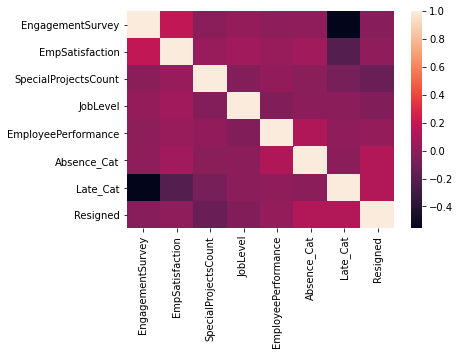

In [10]:
sns.heatmap(df.corr())

In [11]:
cat,num = split_columns(df)
test = cat
test.append('EmpSatisfaction')
test.append('EngagementSurvey')
test.append('EmployeePerformance')
test.append('EngagementSurvey')
test.append('Absence_Cat')
test.append('Late_Cat')

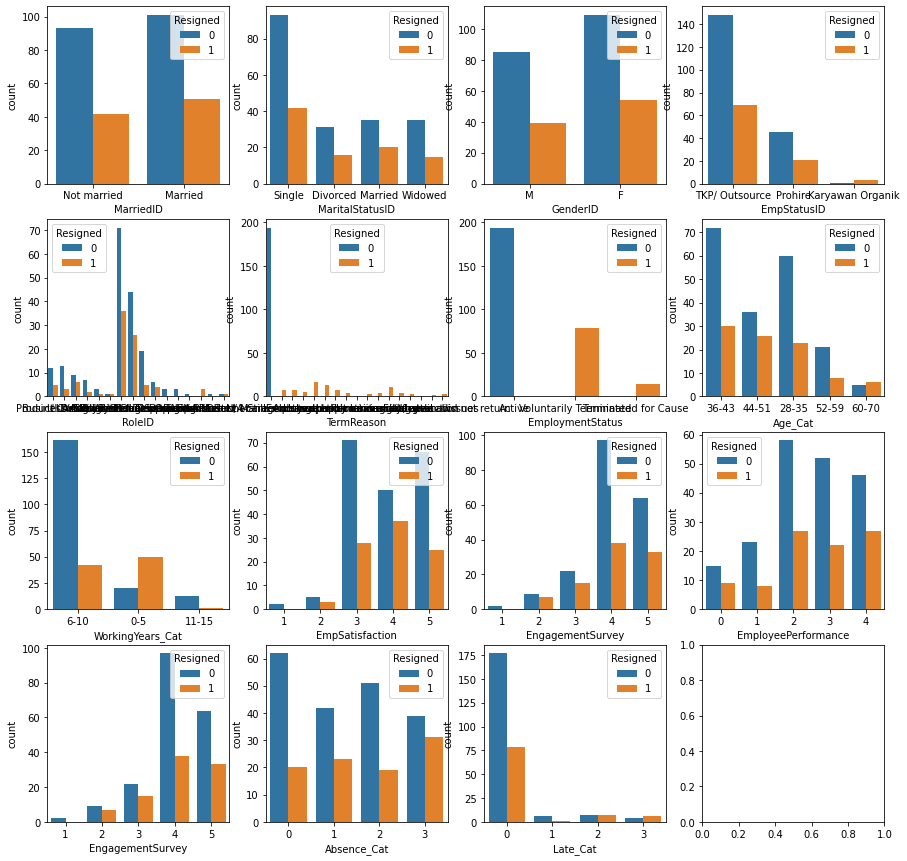

In [12]:
fig,axes=plt.subplots(4,4,figsize=(15,15))
i=0;
for elem in cat:
    sns.countplot(x=df[elem], hue=df['Resigned'], orient='v', ax=axes[int(i/4),(i%4)]);
    i=i+1

In [13]:
df = pd.get_dummies(df)

In [14]:
df.head()

,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,JobLevel,EmployeePerformance,Absence_Cat,Late_Cat,Resigned,MarriedID_Married,MarriedID_Not married,MaritalStatusID_Divorced,MaritalStatusID_Married,MaritalStatusID_Single,MaritalStatusID_Widowed,GenderID_F,GenderID_M,EmpStatusID_Karyawan Organik,EmpStatusID_Prohire,EmpStatusID_TKP/ Outsource,RoleID_Artificial Intelligent,RoleID_Back End Developer,RoleID_Business Analyst,RoleID_DevOps Engineer,RoleID_Digital Product Manager,RoleID_Front End Developer,RoleID_Mobile Developer Android,RoleID_Mobile Developer iOS,RoleID_Product Owner,RoleID_Scrum Master,RoleID_Software Architect,RoleID_System Documentation,RoleID_UI Designer,RoleID_UX Designer,RoleID_UX Researcher,RoleID_UX Writer,TermReason_Another position,TermReason_Fatal attraction,TermReason_Learned that he is a gangster,TermReason_N/A-StillEmployed,TermReason_attendance,TermReason_career change,TermReason_hours,TermReason_maternity leave - did not return,TermReason_medical issues,TermReason_military,TermReason_more money,"TermReason_no-call, no-show",TermReason_performance,TermReason_relocation out of area,TermReason_retiring,TermReason_return to school,TermReason_unhappy,EmploymentStatus_Active,EmploymentStatus_Terminated for Cause,EmploymentStatus_Voluntarily Terminated,Age_Cat_28-35,Age_Cat_36-43,Age_Cat_44-51,Age_Cat_52-59,Age_Cat_60-70,WorkingYears_Cat_0-5,WorkingYears_Cat_11-15,WorkingYears_Cat_6-10
0,5,5,0,2,4,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,5,3,6,2,3,3,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,3,3,0,2,2,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
3,5,5,0,1,4,2,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,5,4,0,1,2,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [15]:
df.shape

(287, 63)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


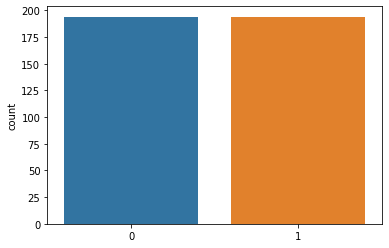

In [33]:
X = df.drop(columns=['Resigned'])
y = df['Resigned']

# handle imbalance target
oversample = SMOTE()
smote = SMOTE(random_state = 0)
X_smote, y_smote = smote.fit_resample(X,y)
sns.countplot(y_smote)

In [20]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3,random_state=42)

Multinomial NB

In [21]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_pred = nb.predict(X_test)

In [22]:
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.98      0.99        53

    accuracy                           0.99       117
   macro avg       0.99      0.99      0.99       117
weighted avg       0.99      0.99      0.99       117



Confusion matrix, without normalization
[[64  0]
 [ 1 52]]


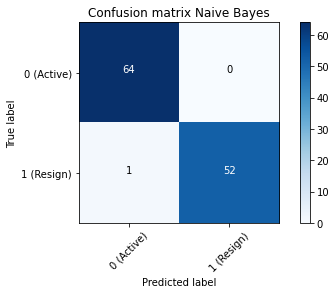

In [23]:
nb_matrix = confusion_matrix(y_test,nb_pred)
plot(nb_matrix, classes=["0 (Active)","1 (Resign)"], title='Confusion matrix Naive Bayes')

Logistic Regression

In [24]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [25]:
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        53

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117



Confusion matrix, without normalization
[[64  0]
 [ 0 53]]


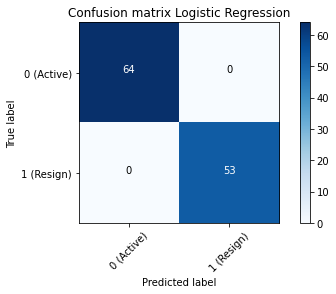

In [26]:
lr_matrix = confusion_matrix(y_test,lr_pred)
plot(lr_matrix, classes=["0 (Active)","1 (Resign)"], title='Confusion matrix Logistic Regression')

Random Forest Classifier

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1,2,3,4,10,15],
     'min_samples_leaf': [3, 5,10,20,30],
     'min_samples_split': [4, 8, 10, 12],
     'n_estimators': [3,5,10,15]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   17.7s finished


{'max_depth': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 15}

In [28]:
rf = grid_search.best_estimator_
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        64
           1       0.91      0.75      0.82        53

    accuracy                           0.85       117
   macro avg       0.87      0.85      0.85       117
weighted avg       0.86      0.85      0.85       117



Confusion matrix, without normalization
[[60  4]
 [13 40]]


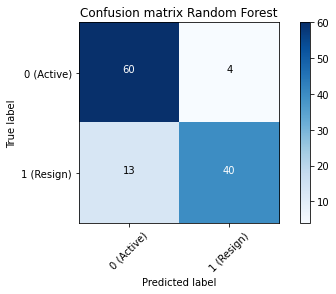

In [29]:
rf_matrix = confusion_matrix(y_test,rf_pred)
plot(rf_matrix, classes=["0 (Active)","1 (Resign)"], title='Confusion matrix Random Forest')

XGBoost

In [30]:
params = {
        'n_estimators': range(50, 250, 50),
        'learning_rate': [0.1, 0.01]
        }
xgb_b = XGBClassifier()
grid_xgb = GridSearchCV(xgb_b,params,verbose=2)
grid_xgb.fit(X_test,y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   0.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   0.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   0.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01],
                         'n_estimators': range(50, 250, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [31]:
xg = grid_xgb.best_estimator_
xg.fit(X_train,y_train)
xg_pred = xg.predict(X_test)
print(classification_report(y_test,xg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        53

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117



Confusion matrix, without normalization
[[64  0]
 [ 0 53]]


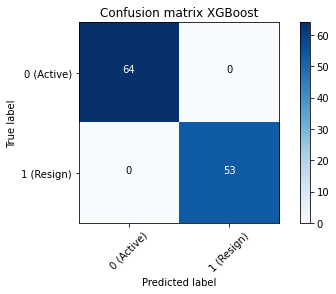

In [32]:
xg_matrix = confusion_matrix(y_test,xg_pred)
plot(xg_matrix, classes=["0 (Active)","1 (Resign)"], title='Confusion matrix XGBoost')